# 0 LiDAR data exploration

**Goal: Load .laz files, inspect structure, and understand metadata & point cloud features.**

✅ Use: laspy or [pylas] to read .laz files.
Consider converting to .las if needed (uncompressed).

✅ Look for:
* Number of points
* Available features: e.g., X, Y, Z, intensity, return number, classification
* Check if there's any labeled data (classification field often exists)
* Visualize a small sample using matplotlib, open3d, or pyvista.

> Tests/Questions to ask:

- How dense is the point cloud?
- Are there ground/non-ground points classified already?
- Are all scans similar in structure?

In [12]:
# Reading in the .laz files
import laspy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pyvista as pv
from pyvista import examples

sns.set_theme(style="whitegrid")


## Load in the data

In [19]:
LAZPATH = "/Users/jamesmurphy/Downloads/bologna.laz"

In [20]:
las = laspy.read(LAZPATH)
x, y, z = las.x, las.y, las.z

In [21]:
# Get point cloud data
points = np.vstack((las.x, las.y, las.z)).transpose()
print(f"Loaded {len(points)} points.")

Loaded 112787346 points.


## Observing the data/metadata

In [22]:
def describe_las(las):
    print(f"Point Format: {las.header.point_format}")
    print(f"Number of Points: {las.header.point_count}")
    print("Available Dimensions:", list(las.point_format.dimension_names))
    print("Bounding Box:")
    print(f"  X: {las.header.mins[0]} to {las.header.maxs[0]}")
    print(f"  Y: {las.header.mins[1]} to {las.header.maxs[1]}")
    print(f"  Z: {las.header.mins[2]} to {las.header.maxs[2]}")
    print("Scale:", las.header.scales)
    print("Offset:", las.header.offsets)
    try:
        print("CRS:", las.header.parse_crs())
    except:
        print("CRS: Not defined")


In [27]:
import pandas as pd
# Preview point data
dims = list(las.point_format.dimension_names)
df = pd.DataFrame({dim: np.asarray(getattr(las, dim)) for dim in dims})

df.head()


,X,Y,Z,intensity,return_number,number_of_returns,scan_direction_flag,edge_of_flight_line,classification,synthetic,key_point,withheld,scan_angle_rank,user_data,point_source_id,gps_time,red,green,blue,height_division
0,-3191405,-582068,-84139,31,1,1,0,0,0,0,0,0,0,0,0,486.909454,6656,4608,4864,0.0
1,-3191085,-582626,-83531,40,1,1,0,0,0,0,0,0,0,0,0,487.611664,6656,4608,4864,0.0
2,-3190450,-584248,-83824,41,1,1,0,0,0,0,0,0,0,0,0,488.012695,6656,4608,4864,0.0
3,-3190827,-582781,-83877,33,1,1,0,0,0,0,0,0,0,0,0,490.922363,10240,8704,5632,0.0
4,-3190565,-584300,-82656,19,1,1,0,0,0,0,0,0,0,0,0,491.022675,10752,8960,5888,0.0


In [7]:
describe_las(las)

Point Format: <PointFormat(3, 4 bytes of extra dims)>
Number of Points: 112787346
Available Dimensions: ['X', 'Y', 'Z', 'intensity', 'return_number', 'number_of_returns', 'scan_direction_flag', 'edge_of_flight_line', 'classification', 'synthetic', 'key_point', 'withheld', 'scan_angle_rank', 'user_data', 'point_source_id', 'gps_time', 'red', 'green', 'blue', 'height_division']
Bounding Box:
  X: -319.2701 to -107.22720000000001
  Y: -315.29970000000003 to 26.5196
  Z: -8.614600000000001 to 34.2946
Scale: [0.0001 0.0001 0.0001]
Offset: [0. 0. 0.]
CRS: None


### The following are the list of classifications defined by IFP
- 0 not yet classified (nothing done yet)
- 1 unclassified (actively marked as nothing)
- 2 ground, sidewalk
- 3,4,5 vegetation, low(gras) medium(shrubbery) high (trees)
- 6 buildings
- 8 street furniture
- 10 street markings
- 11 street, pavement
- 12 bike lanes
- 13 temporary things(bicycles, trashcans)
- 15 cars, trucks

- 20 highlight

## 2-D plotting (sampled)

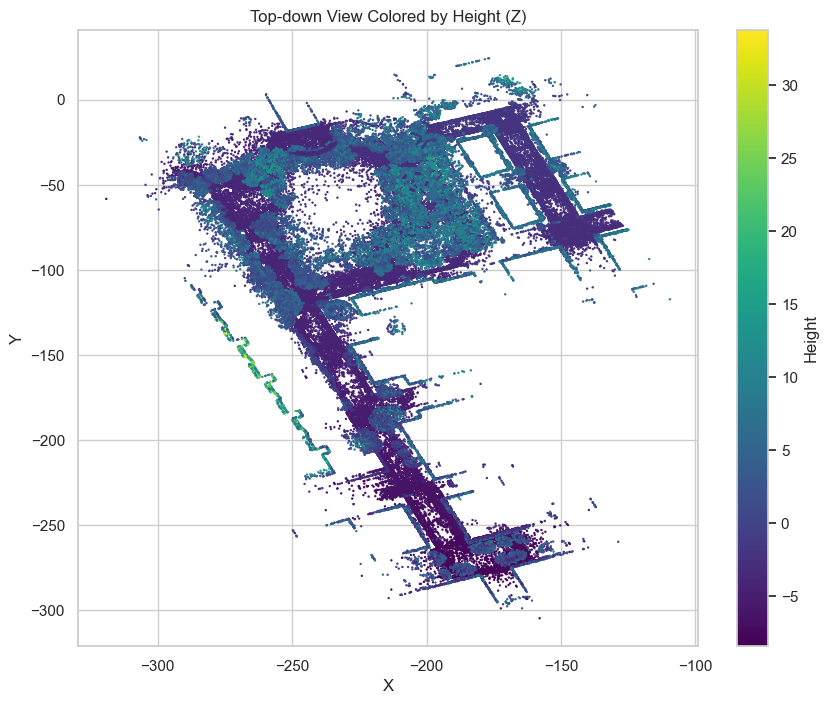

In [8]:
plt.figure(figsize=(10, 8))
sample = 1000  # Plot every Nth point for speed
plt.scatter(las.x[::sample], las.y[::sample], c=las.z[::sample], cmap='viridis', s=0.5)
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Top-down View Colored by Height (Z)")
plt.colorbar(label="Height")
plt.show()


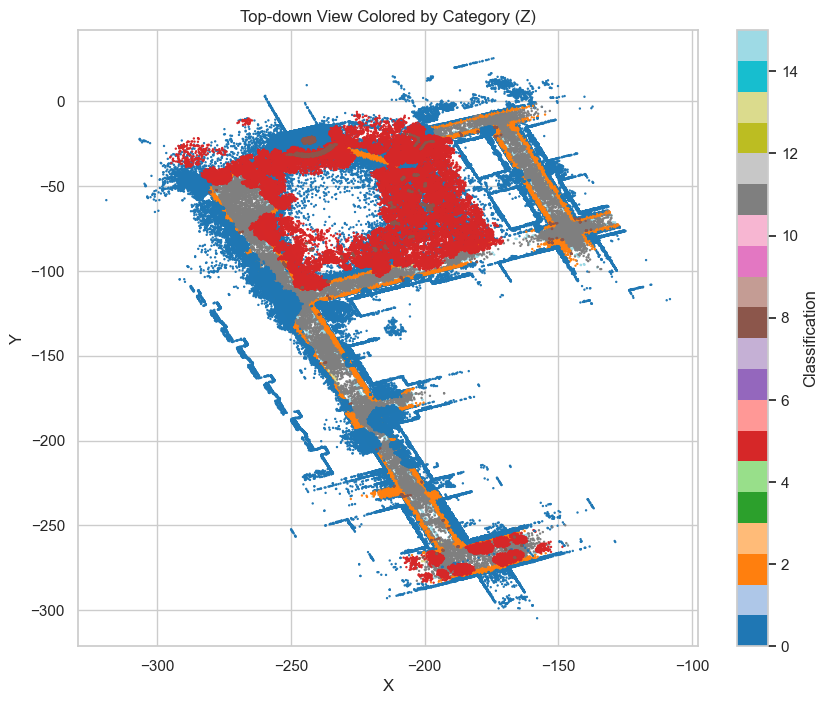

In [34]:
plt.figure(figsize=(10, 8))
sample = 500  # Plot every Nth point for speed
plt.scatter(las.x[::sample], las.y[::sample], c=las.classification[::sample], cmap='tab20', s=0.5)
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Top-down View Colored by Category (Z)")
plt.colorbar(label="Classification")
plt.show()

## 3-D plotting (Sampled)

Under no circumstance try to run the whole laz file. My mac nearly exploded when I did this.

Let's try using open3d. First, we have to downsample the points in the scan. We can do this whilst still keeping the core elements of the scan. If we can't, marginally increase the max_points. We can always downsample later using voxels.

In [37]:
import open3d as o3d

max_points = 1_000_000

indices = np.random.choice(len(las.x), max_points, replace=False)
points = np.vstack((las.x[indices], las.y[indices], las.z[indices])).T


Below we can change the parameters of the ```voxel_size``` to downsample our pointcloud for ease of viewing.

In [39]:
pcd = o3d.geometry.PointCloud()
pcd = pcd.voxel_down_sample(voxel_size=1)  # adjust voxel size as needed
pcd.points = o3d.utility.Vector3dVector(points)

# Optional: estimate normals
# pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=1.0, max_nn=30))

# View interactively
o3d.visualization.draw_geometries([pcd])

### Locating flat surfaces

Open3D has a RANSAC-based plane segmentation algorithm to detect flat surfaces like roads and walls from a 3D pointcloud. The goal is to classify or isolate roads and sidewalks here so this is highly relevant.

```pcd.segment_plane```uses the RANSAC (Random sample consensus) to find a dominant plane within the pointcloud. This typically detects ground, road, building surfaces and most flat structures.

```inliers``` are the indices within the pcd that lie on or near the detected plane. These inliers are likely to be part of the road surface or any flat region.

In [17]:
plane_model, inliers = pcd.segment_plane(distance_threshold=0.2,
                                         ransac_n=3,
                                         num_iterations=1000)
road = pcd.select_by_index(inliers)
o3d.visualization.draw_geometries([road])


NameError: name 'pcd' is not defined

In [ ]:
from dotenv import load_dotenv
import json
from upath import UPath
import os
# Load environment variables from .env file if it exists
load_dotenv()

True

In [10]:

B2D_DIR = UPath(os.getenv("DATA_DIR_FSSPEC_URI"),
                 base_url= os.getenv("DATA_DIR_FSSPEC_BASE_URL"),
                 auth=(os.getenv("DATA_DIR_FSSPEC_USER"),
                       os.getenv("DATA_DIR_FSSPEC_PASS"))
                    )

In [13]:
with (B2D_DIR / "bologna.laz").open("rb") as f:
    las = laspy.read(f)

In [14]:
x, y, z = las.x, las.y, las.z

In [16]:
import pandas as pd
# Preview point data
dims = list(las.point_format.dimension_names)
df = pd.DataFrame({dim: np.asarray(getattr(las, dim)) for dim in dims})

df

,X,Y,Z,intensity,return_number,number_of_returns,scan_direction_flag,edge_of_flight_line,classification,synthetic,key_point,withheld,scan_angle_rank,user_data,point_source_id,gps_time,red,green,blue,height_division
0,-3191405,-582068,-84139,31,1,1,0,0,0,0,0,0,0,0,0,486.909454,6656,4608,4864,0.0
1,-3191085,-582626,-83531,40,1,1,0,0,0,0,0,0,0,0,0,487.611664,6656,4608,4864,0.0
2,-3190450,-584248,-83824,41,1,1,0,0,0,0,0,0,0,0,0,488.012695,6656,4608,4864,0.0
3,-3190827,-582781,-83877,33,1,1,0,0,0,0,0,0,0,0,0,490.922363,10240,8704,5632,0.0
4,-3190565,-584300,-82656,19,1,1,0,0,0,0,0,0,0,0,0,491.022675,10752,8960,5888,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112787341,-1416856,-689052,5226,185,1,1,0,0,8,0,0,0,0,0,0,1382.064941,24576,26368,30464,2.0
112787342,-1417710,-689449,7279,175,1,1,0,0,8,0,0,0,0,0,0,1382.064941,40448,37120,32256,2.0
112787343,-1417167,-688892,3708,175,1,1,0,0,8,0,0,0,0,0,0,1382.064941,24320,22784,18432,2.0
112787344,-1416218,-688725,4395,150,1,1,0,0,8,0,0,0,0,0,0,1382.064941,9728,10752,13824,2.0
